In [1]:
import sys
sys.path.append('../../elastic_rods/python')
sys.path.append('..')

import numpy as np
import MeshFEM, triangulation, mesh, tri_mesh_viewer, vis
import surface_inference, curvature_comparison
from tri_mesh_viewer import RawMesh, TriMeshViewer, LineMeshViewer
from matplotlib import pyplot as plt
from numpy.linalg import norm
import scipy
import scipy.linalg
import scipy.sparse.linalg

In [2]:
import zipfile, re

results = zipfile.ZipFile('sim_results.zip')
experiment_names = np.unique([m.group(1) for m in map(lambda p: re.match(r'(.*)/.*?\.csv', p), (f.filename for f in results.filelist)) if m])

def load_array_from_zip(path, dtype=np.float64):
    return np.loadtxt(results.open(path), delimiter=',', dtype=dtype)

In [3]:
ex=experiment_names[-1]
P  = load_array_from_zip(f'{ex}/p.csv')
E  = load_array_from_zip(f'{ex}/c.csv', dtype=np.uint32)
N  = load_array_from_zip(f'{ex}/d2.csv')
d0 = load_array_from_zip(f'{ex}/d0.csv')
d1 = load_array_from_zip(f'{ex}/d1.csv')

In [11]:
V, F = surface_inference.infer_surface(P, E, N, nonlinearIterations=0)

lineMesh = RawMesh(P, E, N)
vf = vis.fields.VectorField(lineMesh, surface_inference.normalize(N), domainType=vis.fields.DomainType.PER_ELEM)
view = LineMeshViewer(lineMesh, vectorField=vf)
vinterp = TriMeshViewer(mesh.Mesh(V, F), wireframe=True, superView=view)
view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

Also try several rounds of the nonlinear bending energy minimization, with visual feedback:

In [5]:
nlview = TriMeshViewer(mesh.Mesh(V, F))
nlview.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [6]:
Vnonlinear, Fnonlinear=surface_inference.infer_surface(P, E, N, nonlinearIterations=10, nonlinearIterationViewer=nlview)

/Users/yren/Develop/EPFL_LGG/Inflatables


In [7]:
m = mesh.Mesh(Vnonlinear, Fnonlinear)
K = curvature_comparison.quadricFittingCurvatures(m)[0]
Kview = TriMeshViewer(m, scalarField=K)
Kview.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

### Analyze integrated curvature over the entire dataset

In [8]:
allResults = {}
for ex in experiment_names:
    P  = load_array_from_zip(f'{ex}/p.csv')
    E  = load_array_from_zip(f'{ex}/c.csv', dtype=np.uint32)
    N  = load_array_from_zip(f'{ex}/d2.csv')
    d0 = load_array_from_zip(f'{ex}/d0.csv')
    d1 = load_array_from_zip(f'{ex}/d1.csv')
    allResults[ex] = curvature_comparison.curvatureComputations(P, E, N, d1, nonlinearIterations=0)

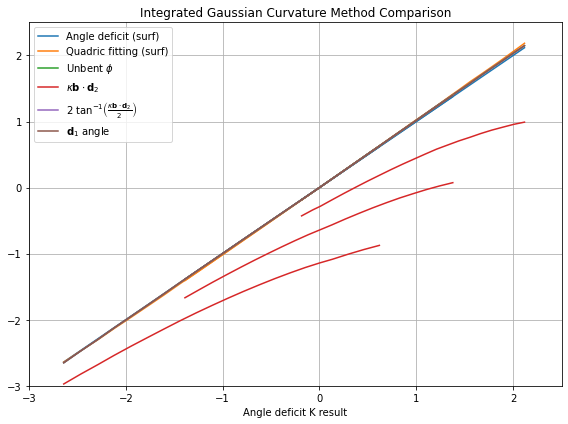

In [9]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 6))
xKey = 'Angle deficit'
keys = ['Angle deficit', 'Quadric fitting', 'unbendPhi', 'Kb . d2', '2 * atan(Kb . d2 / 2)', 'd1 angle']
for n in [5, 6, 7]:
    results = [v for k, v in allResults.items() if int(k[k.find('n_') + 2]) == n]
    sresults = sorted(results, key=lambda a: a[xKey])
    for i, k in enumerate(keys):
        plt.plot([r[xKey] for r in sresults], [r[k] for r in sresults], label=k, color=colors[i])

# Only include one copy of the legends and apply custom labels
customLabels = ['Angle deficit (surf)', 'Quadric fitting (surf)',
                r'Unbent $\phi$',
                r'$\kappa \mathbf{b} \cdot \mathbf{d}_2$',
                r'$2\ \tan^{-1}\left(\frac{\kappa \mathbf{b} \cdot \mathbf{d}_2}{2}\right)$',
                r'$\mathbf{d}_1$ angle']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(keys)], customLabels[0:len(keys)], loc='best')

plt.title('Integrated Gaussian Curvature Method Comparison')
plt.xlabel(f'{xKey} K result')
plt.grid()
plt.tight_layout()
plt.xlim((-3, 2.5))
plt.ylim((-3, 2.5));
#plt.savefig('comparison_nl0.png', dpi=144)

In [10]:
# Compute (absolute) difference in formulas...
[np.abs((r['Angle deficit'] - r['unbendPhi'])) for r in sresults]

[0.010472822854376673,
 0.0069985969154564565,
 0.008757037714802074,
 0.002449551952972584,
 0.0031814443438671347,
 0.0032710748019106894,
 0.0013331675568970525,
 0.002348124093818127,
 0.003360469318244519,
 0.001992662068313278,
 0.001445835267320117,
 0.002913413196083625,
 0.0018387546210378858,
 0.0025016141597685726,
 0.0015526991208539287,
 0.0008903396927142926,
 1.4691581284864696e-12,
 0.002277953364550167,
 0.004197419701866045,
 0.00698008055254401,
 0.008399794668012883]